# Text Message Topics in the  National University of Singapore SMS Corpus Data Set

My central questions regarding the National University of Singapore SMS Corpus data set are the following:
1. Text message senders from which countries send the longest messages?
2. What are some of the most common topics of text messages sent by people from Singapore, India, and the United States? How are they similar, and how are they different?
3. How (if at all) did the common topics of text messages sent by people from Singapore change between 2003 and 2011?
4. Is it possible to use text message data to predict what country a sender is from?

## Importing Needed Software Libraries


Several software libraries will be used to clean the data, normalize it, visualize it, and conduct TF-IDF analysis, word embedding analysis, and n-gram identification. The scikit-learn library will be used to form a Multinomial Naive Bayes supervised machine learning model of the data.

In [1]:
# Import Pandas (to organize and clean the data):
import pandas as pd

In [2]:
# Import visualization libraries (to visualize the data):
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Import regex operations library (to normalize the data):
import re

# Import machine learning library for word embedding (to analyze the data):
import gensim
from gensim.models import Phrases

# Import Counter class of collection containers library (to analyze the data):
from collections import Counter

# Import classes and methods for text tokenizing, lemmatization, stopwords removal, and n-gram evaluation:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Import classes and methods for bag-of-words model building, TF-IDF text analysis, and Multinomial Naive Bayes 
# model building:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Import model performance-measuring methods:
from sklearn.metrics import accuracy_score, classification_report

## Reading in the Data and Cleaning It

The data set must be read into Python before any analysis can be done. I will read it into a Pandas DataFrame, because this data organization structure is easy to work with and very flexible in terms of the data structures it permits.

In [4]:
# Read the .csv data file into a Pandas DataFrame:
sms_text_data = pd.read_csv('clean_nus_sms.csv')

# Print out basic DataFrame information:
print(sms_text_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB
None


Eliminate null values and to remove the unneeded column "Unnamed: 0."

In [5]:
#Some of the records have a null value in the Message column. Since my goal is to investigate the contents of the
# text messages themselves, these records are useless. Drop them from the DataFrame:
sms_text_data = sms_text_data.dropna(subset=['Message'])

# The first column appears to be a running index designed to match the index of a row in a Pandas DataFrame. 
# This column is redundant, so I drop it from the DataFrame:
sms_text_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
# Four text messages have an error message instead of a length. Conveniently, the Message text of these messages
# is the identical error message. Remove these four messages from the DataFrame:

sms_text_data = sms_text_data[sms_text_data.length != 'Err:511']
sms_text_data = sms_text_data[sms_text_data.length != 'Err:510']
sms_text_data = sms_text_data[sms_text_data.length != 'Err:509']
sms_text_data = sms_text_data[sms_text_data.length != 'Err:508']

# Convert the length column from type object to type integer:
sms_text_data.length = pd.to_numeric(sms_text_data.length)

# Split the Date column into a year column and a month column. Add these to the existing DataFrame.
# Since I will not be doing any calculations with either of these columns, I will keep them as type
# object rather than convert them to type integer.
sms_text_data['year'] = sms_text_data.Date.str[0:4]
sms_text_data['month'] = sms_text_data.Date.str[5:]

# Print out DataFrame information again, to make sure nothing blatantly obvious has gone wrong:
print(sms_text_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48591 entries, 0 to 48597
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       48591 non-null  int64 
 1   Message  48591 non-null  object
 2   length   48591 non-null  int64 
 3   country  48591 non-null  object
 4   Date     48591 non-null  object
 5   year     48591 non-null  object
 6   month    48591 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.0+ MB
None


## Exploratory Data Analysis

1. What countries are the text message senders from?
2. How many messages were sent by senders from each country?
3. How many text messages, regardless of sender country, were sent each year?
These questions can be answered with some basic exploratory data analysis, so I conduct such analysis here

In [7]:
# What countries are represented in the data?
print(sms_text_data.country.unique())

['SG' 'MY' 'India' 'Pakistan' 'United States' 'Canada' 'unknown' 'Serbia'
 'United Kingdom' 'France' 'Singapore' 'China' 'Malaysia' 'Sri Lanka'
 'Spain' 'Bangladesh' 'Philippines' 'Macedonia' 'Romania' 'Kenya'
 'Slovenia' 'New Zealand' 'Nigeria' 'Ghana' 'Indonesia' 'Nepal' 'Morocco'
 'USA' 'Lebanon' 'india' 'Trinidad and Tobago' 'INDIA' 'srilanka'
 'jamaica' 'Hungary' 'Australia' 'Italia' 'BARBADOS' 'Turkey' 'UK']


## Changing the names of countries in a more "readable" way

In [8]:
sms_text_data.replace('SG','Singapore', regex = False, inplace = True)
sms_text_data.replace('MY','Malaysia', regex = False, inplace = True)
sms_text_data.replace("srilanka", "Sri Lanka", regex = False, inplace = True)
sms_text_data.replace("UK", "United Kingdom", regex = False, inplace = True)
sms_text_data.replace("USA", "United States", regex = False, inplace = True)
sms_text_data.replace("INDIA", "India", regex = False, inplace = True)
sms_text_data.replace("india", "India", regex = False, inplace = True)
sms_text_data.replace("BARBADOS", "Barbados", regex = False, inplace = True)
sms_text_data.replace("Italia", "Italy", regex = False, inplace = True)
sms_text_data.replace("jamaica", "Jamaica", regex = False, inplace = True)

# Print out the unique values in the country column again, to make sure I didn't miss any unconventional spellings 
# and/or make some other blatantly obvious error:
print(sms_text_data.country.unique())

['Singapore' 'Malaysia' 'India' 'Pakistan' 'United States' 'Canada'
 'unknown' 'Serbia' 'United Kingdom' 'France' 'China' 'Sri Lanka' 'Spain'
 'Bangladesh' 'Philippines' 'Macedonia' 'Romania' 'Kenya' 'Slovenia'
 'New Zealand' 'Nigeria' 'Ghana' 'Indonesia' 'Nepal' 'Morocco' 'Lebanon'
 'Trinidad and Tobago' 'Jamaica' 'Hungary' 'Australia' 'Italy' 'Barbados'
 'Turkey']


## How many messages were sent by senders from each country?

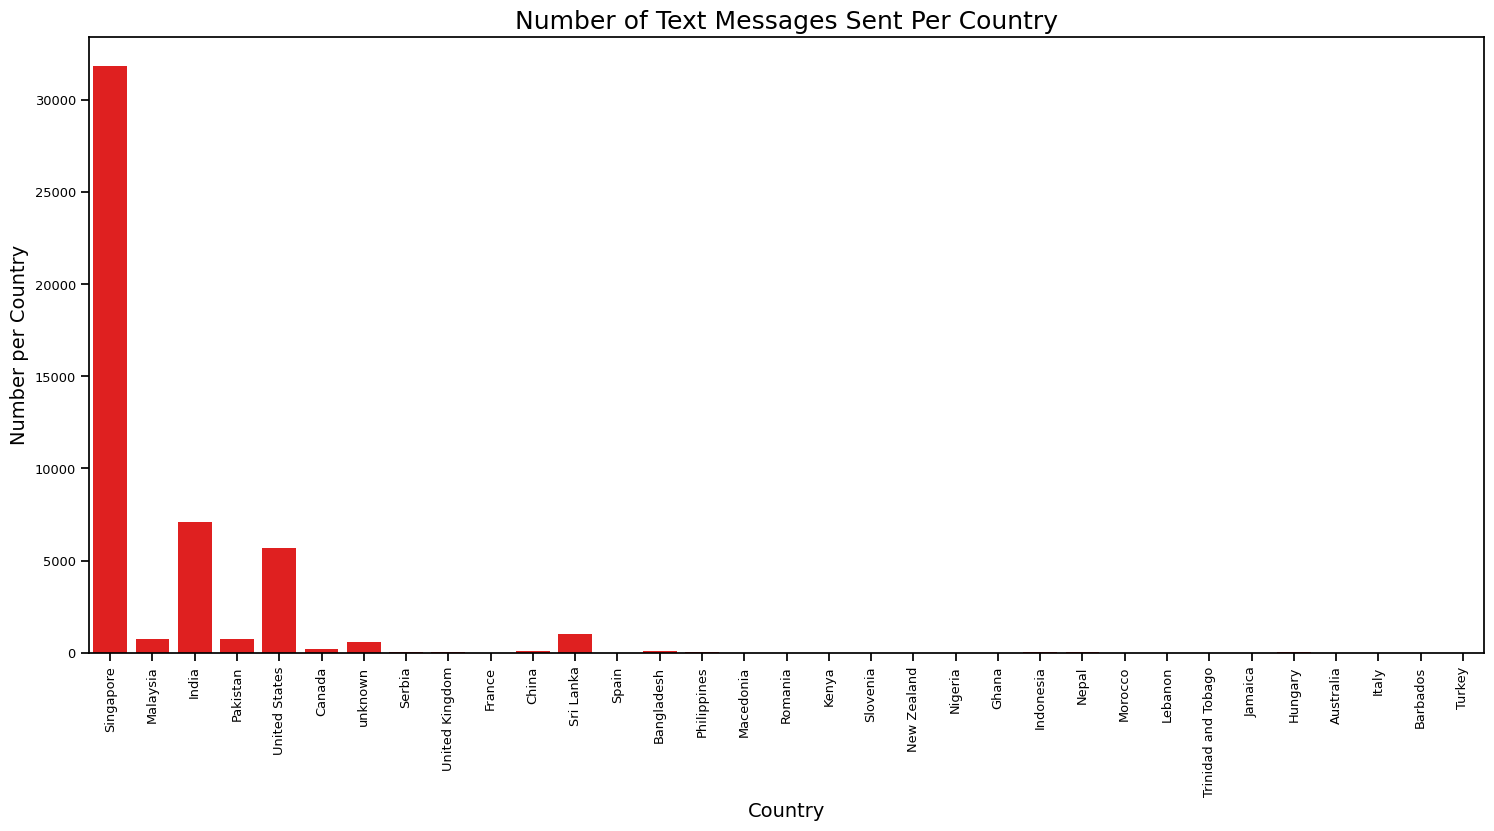

In [9]:
# Make a bar plot of Messages sent per country using Seaborn's countplot() method. I choose to plot the bars in the 
# order in which they appear in the data rather than order them by decreasing counts.

# Set the figure size:
plt.figure(figsize=(18,8))
# Set the context for the notebook (for font scale primarily):
sns.set_context("notebook", font_scale=0.85, rc={"lines.linewidth": 1.5})
# Generate the bar plot, and make each bar the same colour:
sns.countplot(data = sms_text_data, x="country", color = 'red')
# Make the x-axis tick marks easier to read, and make sure the axis labels are informative and readable:
plt.xticks(rotation = 90)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Number per Country", fontsize=14)
plt.title("Number of Text Messages Sent Per Country", fontsize=18)
# Display the plot:
plt.show()

## How many text messages, regardless of sender country, were sent each year?

In [10]:
# What years were the text messages sent?
print(sms_text_data.year.unique())

['2003' '2010' '2011' '2012' '2013' '2014' '2015']


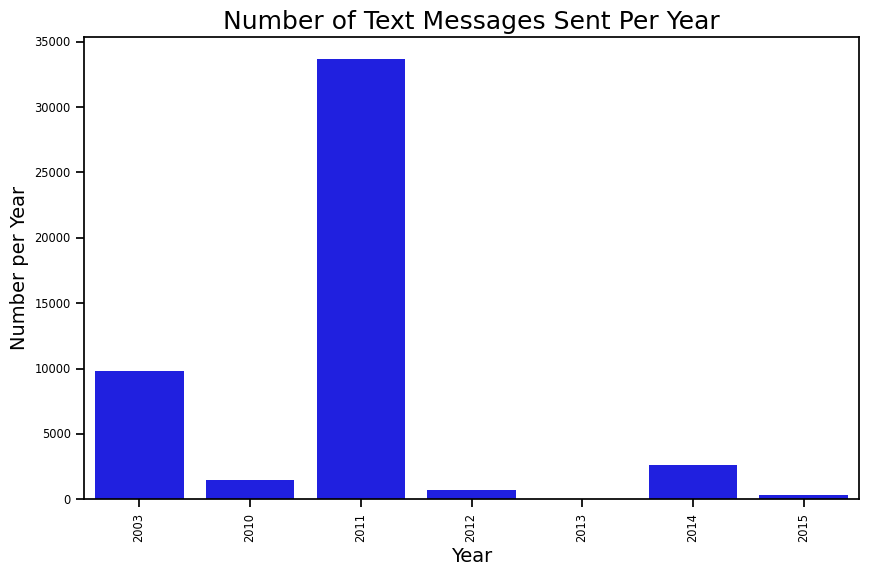

In [11]:
# Make a bar plot of Messages sent per year using Seaborn's countplot() method. I choose to plot the bars in the order
# in which they appear in the data rather than order them by decreasing counts.

# Set the figure size:
plt.figure(figsize=(10,6))
# Set the context for the notebook (for font scale primarily):
sns.set_context("notebook", font_scale=0.75, rc={"lines.linewidth": 1.5})
# Generate the bar plot, and make each bar the same colour:
sns.countplot(data = sms_text_data, x="year", color = 'blue')
# Make the x-axis labels easier to read, and make sure the axis labels are informative and readable:
plt.xticks(rotation = 90)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number per Year", fontsize=14)
plt.title("Number of Text Messages Sent Per Year", fontsize=18)
# Display the plot:
plt.show()

# Text Pre-Processing

In [12]:
# Define a few noise removal functions to make noise removal on Messages in the DataFrame easier:

# Replace punctuation marks and standard symbols with a single space:
def remove_punctuation(text):
    return re.sub(r',|\.|\:|;|-|/|&|!|\?|\(|\)|\+|@|<|>|#|~|=|\$|\*|[|]|{|}',' ',text)

# Replace apostrophes with a single space:
def replace_apostrophe(text):
    return re.sub(r"'",' ',text)

# Replace the special character ┾ with a single space:
def replace_crossmark(text):
    return re.sub(r"┾",' ',text)

# Implementing some of the above functions may introduce multiple whitespaces ('  ' or '   ', etc.)
# Replace any instances of multiple whitespaces with a single whitespace:
def remove_xtra_whitespace(text):
    return re.sub(r'\s+', ' ', text)

# The following code was written by the curriculum developers at Codecademy in their lesson on word lemmatization. 
# I have not changed any of the original code they wrote. The purpose of the code is to determine which part of 
# speech a word most probably belongs to -- noun, verb, adjective, adverb -- and to return that part of speech.
# The result of that code is in turn handed off to a word lemmatizer, so it "knows" which part of speech a word
# most likely belongs to.
def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len([item for item in probable_part_of_speech if item.pos()=="n"])
    pos_counts["v"] = len([item for item in probable_part_of_speech if item.pos()=="v"])
    pos_counts["a"] = len([item for item in probable_part_of_speech if item.pos()=="a"])
    pos_counts["r"] = len([item for item in probable_part_of_speech if item.pos()=="r"])
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

#### Noise Removal 

In [13]:
# Use some of the above functions to remove noise from the Messages, and to begin normalizing them:

# The specific pattern of text  was observed in a number of text messages. Replace it with a single space:
sms_text_data.Message = sms_text_data.Message.replace('', ' ', regex = False)

# Remove apostrophes and punctuation/certain symbols from the Messages:
sms_text_data.Message = sms_text_data.Message.apply(lambda x: replace_apostrophe(x))
sms_text_data.Message = sms_text_data.Message.apply(lambda x: replace_crossmark(x))
sms_text_data.Message = sms_text_data.Message.apply(lambda x: remove_punctuation(x))

# Remove any extra whitespace inadvertantly added to the Messages:
sms_text_data.Message = sms_text_data.Message.apply(lambda x: remove_xtra_whitespace(x))

# Convert all characters to lowercase:
sms_text_data.Message = sms_text_data.Message.apply(lambda x: x.lower())

#### Tokenization

In [14]:
# Break each text message up into individual words using the NLTK method word_tokenize:
sms_text_data['Message_tokenized'] = sms_text_data.Message.apply(lambda text_message: word_tokenize(text_message))

#### Stopword Removal

In [15]:
import nltk
nltk.download('stopwords')
# Load a set of common English stopwords for stopword removal:
eng_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Remove stopwords from the text Messages.
# In retrospect, this probably would have been easier to do if the tokenized messages were in a list rather than a
# DataFrame column, but that is a lesson that I will carry into my next NLP project.

# Make a new column in the DataFrame which contains, for now, empty lists:
sms_text_data['Message_tokenized_nostop'] = [list() for i in range(len(sms_text_data['Message_tokenized']))]

# Loop over each row of the DataFrame, gather up the tokenized text, and loop through each token to see whether 
# it is a stopword. If it is NOT a stopword, add it to the list in Message_tokenized_nostop for that particular 
# row; otherwise, leave the word out of said list:
# Begin loop:
for i in range(len(sms_text_data['Message_tokenized'])):
    # Pluck off the list of tokens corresponding to this particular row:
    thistext = sms_text_data.Message_tokenized.iloc[i]
    # Loop over tokens in the current list of tokens:
    for word in thistext:
        # If the token in question is not in the list of English stopwords, add it to the list of tokens in
        # Message_tokenized_nostop for this particular row.
        if not word in eng_stopwords:
            sms_text_data.Message_tokenized_nostop.iloc[i].append(word)

# Print out the header for the new column Message_tokenized_nostop to make sure that nothing blatantly obvious has gone
# wrong (with the first 5 records at least):
print(sms_text_data.Message_tokenized_nostop.head())

0                              [bugis, oso, near, wat]
1    [go, jurong, point, crazy, available, bugis, n...
2                    [dunno, lets, go, learn, pilates]
3    [den, weekdays, got, special, price, haiz, can...
4                                    [meet, lunch, la]
Name: Message_tokenized_nostop, dtype: object


#### Word Lemmatization

In [17]:
# Instantiate an object of the WordNetLemmatizer() class:
lemmatizer = WordNetLemmatizer()

In [18]:
import nltk
nltk.download('omw-1.4')
# Lemmatize the remaining words in the text messages.
# In retrospect, this also probably would have been easier to do if the tokenized messages with stopwords removed were
# in a list rather than a DataFrame column, but that is another lesson that I will carry into my next NLP project.

# Make a new column in the DataFrame which contains, for now, empty lists:
sms_text_data['Msg_token_nostop_lemmmed'] = [list() for i in range(len(sms_text_data['Message_tokenized_nostop']))]

# Loop over each row, gather up the tokenized text, go through the tokenized text word by word to lemmatize it (after
# determining which part of speech the word most probably belongs to), and add the lemmatized word to the list in
# Msg_token_nostop_lemmed for that particular row:
# Begin loop:
for i in range(len(sms_text_data['Message_tokenized_nostop'])):
    # Pluck off the list of tokens corresponding to this particular row:
    thistext = sms_text_data.Message_tokenized_nostop.iloc[i]
    # Loop over tokens in the current list of tokens: 
    for word in thistext:
        # Lemmatize the token after first determining its likely part of speech:
        lemmatized = lemmatizer.lemmatize(word, get_part_of_speech(word))
        # Add the lemmatized token to the list of tokens in Msg_token_nostop_lemmed for this particular row:
        sms_text_data.Msg_token_nostop_lemmmed.iloc[i].append(lemmatized)

# Print out the header for the new column Msg_token_nostop_lemmmed to make sure that nothing blatantly obvious has gone
# wrong (with the first 5 records at least):
print(sms_text_data.Msg_token_nostop_lemmmed.head())

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\soner\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0                              [bugis, oso, near, wat]
1    [go, jurong, point, crazy, available, bugis, n...
2                      [dunno, let, go, learn, pilate]
3    [den, weekday, get, special, price, haiz, cant...
4                                    [meet, lunch, la]
Name: Msg_token_nostop_lemmmed, dtype: object


### Average Text Lengths Per Country

In [19]:
# Group records by country and calculate the average length of Messages:
avg_text_lengths = sms_text_data.groupby(['country']).length.mean().reset_index()

# Sort the DataFrame by average length of Messages:
avg_text_lengths.sort_values(by=['length'], ascending = False, inplace = True)

# Print out the names of the five countries with the biggest average length of Messages:
print(avg_text_lengths.nlargest(5,'length'))

      country      length
3      Canada  103.782828
27  Sri Lanka   94.493792
14  Macedonia   92.200000
6       Ghana   73.500000
24  Singapore   55.996134


### Important Words in Messages: TF and TF-IDF Analysis

What are some of the most common topics of text messages sent by people from Singapore, India, and the United States? How are they similar, and how are they different?" and "How (if at all) did the common topics of text messages sent by people from Singapore change between 2003 and 2011?" I will be exploring three main avenues of addressing these questions. I will begin by seeing what I can learn by conducting term frequency (TF) and term frequency-inverse document frequency (TF-IDF) analysis on text messages from users from Singapore, India, and the United States. "Term frequency" simply refers to how often a term/word appears in a corpus of documents

#### Texts from people from Singapore:

In [20]:
# Separate out text messages from users from Singapore, India, and the United States into separate DataFrames for
# easier analysis:
sg_sms_text_data = sms_text_data[sms_text_data.country == 'Singapore']
in_sms_text_data = sms_text_data[sms_text_data.country == 'India']
us_sms_text_data = sms_text_data[sms_text_data.country == 'United States']

#### Texts from people from Singapore:

In [21]:
# Term-Frequency analysis:

# Initialize an empty list:
sg_corpus = []

# Loop over records and, for each record, append each word of the associated message to the list sg_corpus. This
# creates a list of all non-stopword, lemmatized words in all text messages sent by users from Singapore:
# Begin loop:
for i in range(len(sg_sms_text_data['Msg_token_nostop_lemmmed'])):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thistext = sg_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Loop over tokens in the current list:
    for word in thistext:
        # Append the current token to the master list sg_corpus:
        sg_corpus.append(word)

# Instantiate a Counter class object from the iterable list sg_corpus:
sg_count_of_words = Counter(sg_corpus)
# Since objects of the Counter class are a subclass of dictionaries, convert the Counter object sg_count_of_words
# to a Pandas DataFrame:
sg_word_counts = pd.DataFrame.from_dict(sg_count_of_words, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
sg_word_counts.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
sg_word_counts.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly used words:
print(sg_word_counts.nlargest(15,'count'))

# I realized after completing the project that simply using the Counter method most_common() would have been faster and
# perhaps more efficient than what I did above. This is another lesson that I will be taking into my next NLP project.

        word  count
129        u   8283
93      haha   6630
4         go   4477
16       get   3097
2518     lol   2818
247       ok   1813
1454  hahaha   1752
263     late   1707
120     time   1631
153     okay   1608
1729      le   1458
100    think   1448
43      come   1371
38      meet   1368
64       one   1264


In [22]:
# Term Frequency-Inverse Document Frequency analysis:

# Initialize an empty list:
sing_corpus = []

# Loop over records and, for each record, join the list of non-stopword, lemmatized words into one string, then append
# that string to the list of text message strings to be stored in sing_corpus:

# Begin loop:
for i in range(len(sg_sms_text_data.Msg_token_nostop_lemmmed)):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thislist = sg_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Join the tokens in the current list into one string, separating them by commas:
    thisstring = ', '.join(thislist) 
    # Append the current string to the list sing_corpus:
    sing_corpus.append(thisstring)

# Instantiate a TfidVectorizer object, making sure that inverse document frequency will be calculated:
sing_vectorizer = TfidfVectorizer(use_idf=True)
# Fit the sing_vectorizer object to the corpus contained in sing_corpus:
sing_tfidf_vectors = sing_vectorizer.fit_transform(sing_corpus)

In [25]:
# Term-Frequency analysis:

# Initialize an empty list:
sg_corpus = []

# Loop over records and, for each record, append each word of the associated message to the list sg_corpus. This
# creates a list of all non-stopword, lemmatized words in all text messages sent by users from Singapore:
# Begin loop:
for i in range(len(sg_sms_text_data['Msg_token_nostop_lemmmed'])):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thistext = sg_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Loop over tokens in the current list:
    for word in thistext:
        # Append the current token to the master list sg_corpus:
        sg_corpus.append(word)

# Instantiate a Counter class object from the iterable list sg_corpus:
sg_count_of_words = Counter(sg_corpus)
# Since objects of the Counter class are a subclass of dictionaries, convert the Counter object sg_count_of_words
# to a Pandas DataFrame:
sg_word_counts = pd.DataFrame.from_dict(sg_count_of_words, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
sg_word_counts.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
sg_word_counts.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly used words:
print(sg_word_counts.nlargest(15,'count'))

# I realized after completing the project that simply using the Counter method most_common() would have been faster and
# perhaps more efficient than what I did above. This is another lesson that I will be taking into my next NLP project.

        word  count
129        u   8283
93      haha   6630
4         go   4477
16       get   3097
2518     lol   2818
247       ok   1813
1454  hahaha   1752
263     late   1707
120     time   1631
153     okay   1608
1729      le   1458
100    think   1448
43      come   1371
38      meet   1368
64       one   1264


#### Texts from people from India:

In [29]:
# Term-Frequency analysis:

# Initialize an empty list:
in_corpus = []

# Loop over records and, for each record, append each word of the associated message to the list in_corpus. This
# creates a list of all non-stopword, lemmatized words in all text messages sent by users from India:
# Begin loop:
for i in range(len(in_sms_text_data['Msg_token_nostop_lemmmed'])):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thistext = in_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Loop over tokens in the current list:
    for word in thistext:
        # Append the current token to the master list in_corpus:
        in_corpus.append(word)

# Instantiate a Counter class object from the iterable list in_corpus:
in_count_of_words = Counter(in_corpus)
# Convert the Counter object in_count_of_words to a Pandas DataFrame:
in_word_counts = pd.DataFrame.from_dict(in_count_of_words, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
in_word_counts.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
in_word_counts.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly used words
print(in_word_counts.nlargest(15,'count'))

     word  count
48      u   1190
0       k    403
83   come    393
578     2    338
33     ur    323
527  call    323
214   get    302
529    ok    301
297    go    300
194     r    293
45    hey    247
487    ``    239
128     n    238
397   day    237
412  good    232


In [30]:
# Term Frequency-Inverse Document Frequency analysis:

# Initialize an empty list:
india_corpus = []

# Loop over records and, for each record, join the list of non-stopword, lemmatized words into one string, then append
# that string to the list of text message strings to be stored in india_corpus:
# Begin loop:
for i in range(len(in_sms_text_data.Msg_token_nostop_lemmmed)):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thislist = in_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Join the tokens in the current list into one string, separating them by commas:
    thisstring = ', '.join(thislist) 
    # Append the current string to the list india_corpus:
    india_corpus.append(thisstring)

# Instantiate a TfidVectorizer object, making sure that inverse document frequency will be calculated:    
india_vectorizer = TfidfVectorizer(use_idf=True)
# Fit the india_vectorizer object to the corpus contained in india_corpus:
india_tfidf_vectors = india_vectorizer.fit_transform(india_corpus)

# Begin loop over vectors:
for i in range(len(in_sms_text_data.Msg_token_nostop_lemmmed)):
    # Pluck off the tf-idf vector corresponding to the current record, i.e. text message:
    tfidf_vector = india_tfidf_vectors[i]
    # Place tf-idf values in a Pandas DataFrame, setting the indices of the DataFrame to the words found in the
    # corpus of text messages:
    tfidf_results = pd.DataFrame(tfidf_vector.T.todense(), index = india_vectorizer.get_feature_names(), \
                                 columns = ["TF-IDF Score"])
    # Keep only those records in tfidf_results which have a non-zero tf-idf score:
    nonzero_words = tfidf_results[tfidf_results['TF-IDF Score'] > 0.0]
    # If this is the first vector, make the DataFrame of non-zero tf-idf words equal to the current DataFrame 
    # nonzero_words:
    if i == 0:
        india_top_tfidf_scores = nonzero_words
    # Otherwise, append the current DataFrame nonzero_words to the already extant DataFrame india_top_tfidf_scores:    
    else:
        india_top_tfidf_scores = india_top_tfidf_scores.append(nonzero_words)

# Convert the DataFrame india_top_tfidf_words to a list:
india_top_tfidf_words = india_top_tfidf_scores.index[india_top_tfidf_scores['TF-IDF Score'] > 0.0].to_list()

# Instantiate a Counter class from the iterable list india_top_tfidf_words:
india_count_of_top_tfidf_words = Counter(india_top_tfidf_words)
# Convert the Counter object india_count_of_top_ifidf_words to a Pandas DataFrame:
india_top_tfidf_word_counts = pd.DataFrame.from_dict(india_count_of_top_tfidf_words, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
india_top_tfidf_word_counts.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
india_top_tfidf_word_counts.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly occuring important words in text messages from users from India:
print(india_top_tfidf_word_counts.nlargest(15,'count'))

     word  count
79   come    372
511  call    302
514    ok    289
206   get    286
284    go    283
31     ur    248
44    hey    247
394  good    220
136    da    204
383   day    200
602    hi    184
76   send    170
369  dear    160
46   tell    158
59     na    151


### Texts from people from the United States:

In [31]:
# Term-Frequency analysis:

# Initialize an empty list:
us_corpus = []

# Loop over records and, for each record, append each word of the associated message to the list us_corpus. This
# creates a list of all non-stopword, lemmatized words in all texts messages sent by users from the United States:

# Begin loop:
for i in range(len(us_sms_text_data['Msg_token_nostop_lemmmed'])):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thistext = us_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Loop over tokens in the current list:
    for word in thistext:
        # Append the current token to the master list us_corpus:
        us_corpus.append(word)

# Instantiate a Counter class object from the iterable list us_corpus:
us_count_of_words = Counter(us_corpus)
# Convert the Counter object us_count_of_words to a Pandas DataFrame:
us_word_counts = pd.DataFrame.from_dict(us_count_of_words, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
us_word_counts.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
us_word_counts.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly used words
print(us_word_counts.nlargest(15,'count'))

       word  count
84      get    602
115    know    340
418       u    336
121      go    315
5       lol    278
54     like    262
68   thanks    256
222    want    252
215    come    232
66     yeah    207
345    time    205
685      hi    201
188   think    192
417     see    189
407    love    182


In [32]:
# Term Frequency-Inverse Document Frequency analysis:

# Initialize an empty list:
usa_corpus = []

# Loop over records and, for each record, join the list of non-stopword, lemmatized words into one string, then append
# that string to the list of text message strings to be stored in sing_corpus:
# Begin loop:
for i in range(len(us_sms_text_data.Msg_token_nostop_lemmmed)):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thislist = us_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Join the tokens in the current list into one string, separating them by commas:
    thisstring = ', '.join(thislist) 
    # Append the current string to the list usa_corpus:
    usa_corpus.append(thisstring)

# Instantiate a TfidVectorizer object, making sure that inverse document frequency will be calculated:
usa_vectorizer = TfidfVectorizer(use_idf=True)
# Fit the usa_vectorizer object to the corpus contained in usa_corpus:
usa_tfidf_vectors = usa_vectorizer.fit_transform(usa_corpus)

# Begin loop over vectors:
for i in range(len(us_sms_text_data.Msg_token_nostop_lemmmed)):
    # Pluck off the tf-idf vector corresponding to the current record, i.e. text message:
    tfidf_vector = usa_tfidf_vectors[i]
    # Place tf-idf values in a Pandas DataFrame, setting the indices of the DataFrame to the words found in the
    # corpus of text messages:
    tfidf_results = pd.DataFrame(tfidf_vector.T.todense(), index = usa_vectorizer.get_feature_names(), \
                                 columns = ["TF-IDF Score"])
    # Keep only those records in tfidf_results which have a non-zero tf-idf score:
    nonzero_words = tfidf_results[tfidf_results['TF-IDF Score'] > 0.0]
    # If this is the first vector, make the DataFrame of non-zero tf-idf words equal to the current DataFrame 
    # nonzero_words:
    if i == 0:
        usa_top_tfidf_scores = nonzero_words
    # Otherwise, append the current DataFrame nonzero_words to the already extant DataFrame usa_top_tfidf_scores:
    else:
        usa_top_tfidf_scores = usa_top_tfidf_scores.append(nonzero_words)

# Convert the DataFrame usa_top_tfidf_words to a list:
usa_top_tfidf_words = usa_top_tfidf_scores.index[usa_top_tfidf_scores['TF-IDF Score'] > 0.0].to_list()

# Instantiate a Counter class from the iterable list usa_top_tfidf_words:
usa_count_of_top_tfidf_words = Counter(usa_top_tfidf_words)
# Convert the Counter object usa_count_of_top_ifidf_words to a Pandas DataFrame:
usa_top_tfidf_word_counts = pd.DataFrame.from_dict(usa_count_of_top_tfidf_words, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
usa_top_tfidf_word_counts.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
usa_top_tfidf_word_counts.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly occuring important words in text messages from users from the United States:
print(usa_top_tfidf_word_counts.nlargest(15,'count'))

       word  count
81      get    562
111    know    324
118      go    298
4       lol    271
65   thanks    246
52     like    243
221    want    240
208    come    225
66     yeah    206
667      hi    201
347    time    192
184   think    186
407     see    185
191      ok    173
396    love    171


# Important Words in Messages: TF and TF-IDF Analysis Comparing and Contrasting Texts from Singapore Eight Years Apart

How (if at all) did the common topics of text messages sent by people from Singapore change between 2003 and 2011?" I will again engage in TF and TF-IDF analysis as I attempt to answer this question. So in a sense, this analysis repeats what I have done above, except that now I am splitting the corpus of text messages from people from Singapore into two subsets based on the year the messages were sent

In [33]:
# Select texts sent by users from Singapore in 2011, and texts sent by users fron Singapore in 2003:
sg_sms_text_data_2011 = sg_sms_text_data[sg_sms_text_data.year == '2011']
sg_sms_text_data_2003 = sg_sms_text_data[sg_sms_text_data.year == '2003']

Texts Sent in 2003

In [34]:
# Term-Frequency analysis:

# Initialize an empty list:
sg_corpus_2003 = []

# Loop over records and, for each record, append each word of the associated message to the list sg_corpus_2003. This
# creates a list of all non-stopword, lemmatized words in all text messages sent by users from Singapore in 2003:
# Begin loop:
for i in range(len(sg_sms_text_data_2003['Msg_token_nostop_lemmmed'])):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thistext = sg_sms_text_data_2003.Msg_token_nostop_lemmmed.iloc[i]
    # Loop over tokens in the current list:
    for word in thistext:
        # Append the current token to the master list sg_corpus_2003:
        sg_corpus_2003.append(word)

# Instantiate a Counter class object from the iterable list sg_corpus_2003:
sg_count_of_words_2003 = Counter(sg_corpus_2003)
# Convert the Counter object sg_count_of_words_2003 to a Pandas DataFrame:
sg_word_counts_2003 = pd.DataFrame.from_dict(sg_count_of_words_2003, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
sg_word_counts_2003.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
sg_word_counts_2003.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly used words
print(sg_word_counts_2003.nlargest(15,'count'))

     word  count
129     u   3731
4      go   1605
16    get    969
13      e    873
41      ü    798
210   lor    784
225    ur    660
247    ok    658
190     2    642
120  time    588
38   meet    586
66    wan    579
263  late    568
3     wat    536
43   come    516


In [35]:
# Term Frequency-Inverse Document Frequency analysis:

# Initialize an empty list:
sing_corpus_2003 = []

# Loop over records and, for each record, join the list of non-stopword, lemmatized words into one string, then append
# that string to the list of text message strings to be stored in sing_corpus_2003:
# Begin loop:
for i in range(len(sg_sms_text_data_2003.Msg_token_nostop_lemmmed)):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thislist = sg_sms_text_data_2003.Msg_token_nostop_lemmmed.iloc[i]
    # Join the tokens in the current list into one string, separating them by commas:
    thisstring = ', '.join(thislist)
    # Append the current string to the list sing_corpus_2003:
    sing_corpus_2003.append(thisstring)

# Instantiate a TfidVectorizer object, making sure that inverse document frequency will be calculated:    
sing_vectorizer_2003 = TfidfVectorizer(use_idf=True)
# Fit the sing_vectorizer_2003 object to the corpus contained in india_corpus:
sing_tfidf_vectors_2003 = sing_vectorizer_2003.fit_transform(sing_corpus_2003)

# Begin loop over vectors:
for i in range(len(sg_sms_text_data_2003.Msg_token_nostop_lemmmed)):
    # Pluck off the tf-idf vector corresponding to the current record, i.e. text message:
    tfidf_vector = sing_tfidf_vectors_2003[i]
    # Place tf-idf values in a Pandas DataFrame, setting the indices of the DataFrame to the words found in the
    # corpus of text messages:
    tfidf_results = pd.DataFrame(tfidf_vector.T.todense(), index = sing_vectorizer_2003.get_feature_names(), \
                                 columns = ["TF-IDF Score"])
    # Keep only those records in tfidf_results which have a non-zero tf-idf score:
    nonzero_words = tfidf_results[tfidf_results['TF-IDF Score'] > 0.0]
    # If this is the first vector, make the DataFrame of non-zero tf-idf words equal to the current DataFrame 
    # nonzero_words:
    if i == 0:
        sing_top_tfidf_scores_2003 = nonzero_words
    # Otherwise, append the current DataFrame nonzero_words to the already extant DataFrame sing_top_tfidf_scores_2003: 
    else:
        sing_top_tfidf_scores_2003 = sing_top_tfidf_scores_2003.append(nonzero_words)

# Convert the DataFrame sing_top_tfidf_scores_2003 to a list:
sing_top_tfidf_words_2003 = sing_top_tfidf_scores_2003.index[sing_top_tfidf_scores_2003['TF-IDF Score'] > 0.0].to_list()

# Instantiate a Counter class from the iterable list sing_top_tfidf_words_2003:
sing_count_of_top_tfidf_words_2003 = Counter(sing_top_tfidf_words_2003)
# Convert the Counter object sing_count_of_top_tfidf_words_2003 to a Pandas DataFrame:
sing_top_tfidf_word_counts_2003 = pd.DataFrame.from_dict(sing_count_of_top_tfidf_words_2003, \
                                                         orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
sing_top_tfidf_word_counts_2003.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
sing_top_tfidf_word_counts_2003.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly occuring important words in text messages in 2003:
print(sing_top_tfidf_word_counts_2003.nlargest(15,'count'))

     word  count
10     go   1435
9     get    891
195   lor    717
238    ok    628
214    ur    607
116  time    567
36   meet    555
80    wan    548
251  late    546
3     wat    517
38   come    500
53    hey    488
89   haha    457
153   dun    413
74    one    374


#### Text Messages Sent in 2011

In [36]:
# Term-Frequency analysis:

# Initialize an empty list:
sg_corpus_2011 = []

# Loop over records and, for each record, append each word of the associated message to the list sg_corpus_2011. This
# creates a list of all non-stopword, lemmatized words in all text messages sent by users from Singapore in 2011:
# Begin loop:
for i in range(len(sg_sms_text_data_2011['Msg_token_nostop_lemmmed'])):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thistext = sg_sms_text_data_2011.Msg_token_nostop_lemmmed.iloc[i]
    # Loop over tokens in the current list:
    for word in thistext:
        # Append the current token to the master list sg_corpus_2011:
        sg_corpus_2011.append(word)

# Instantiate a Counter class object from the iterable list sg_corpus_2011:
sg_count_of_words_2011 = Counter(sg_corpus_2011)
# Convert the Counter object sg_count_of_words_2011 to a Pandas DataFrame:
sg_word_counts_2011 = pd.DataFrame.from_dict(sg_count_of_words_2011, orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
sg_word_counts_2011.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
sg_word_counts_2011.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly used words
print(sg_word_counts_2011.nlargest(15,'count'))

        word  count
35      haha   6153
2          u   4546
126       go   2872
4306     lol   2807
83       get   2127
640   hahaha   1746
1252    okay   1512
219       le   1391
141       ok   1155
168     late   1139
194    think   1127
265     yeah   1046
123     time   1042
16        oh    963
789       eh    938


In [38]:
# Term Frequency-Inverse Document Frequency analysis:

# Initialize an empty list:
sing_corpus_2011 = []

# Loop over records and, for each record, join the list of non-stopword, lemmatized words into one string, then append
# that string to the list of text message strings to be stored in sing_corpus_2011:
# Begin loop:
for i in range(len(sg_sms_text_data_2011.Msg_token_nostop_lemmmed)):
    # Pluck off the list containing non-stopword, lemmatized words of the Message associated with this record:
    thislist = sg_sms_text_data_2011.Msg_token_nostop_lemmmed.iloc[i]
    # Join the tokens in the current list into one string, separating them by commas:
    thisstring = ', '.join(thislist) 
    # Append the current string to the list sing_corpus_2011:
    sing_corpus_2011.append(thisstring)

# Instantiate a TfidVectorizer object, making sure that inverse document frequency will be calculated:    
sing_vectorizer_2011 = TfidfVectorizer(use_idf=True)
# Fit the sing_vectorizer_2003 object to the corpus contained in india_corpus:
sing_tfidf_vectors_2011 = sing_vectorizer_2011.fit_transform(sing_corpus_2011)

# Begin loop over vectors:
for i in range(len(sg_sms_text_data_2011.Msg_token_nostop_lemmmed)):
    # Pluck off the tf-idf vector corresponding to the current record, i.e. text message:
    tfidf_vector = sing_tfidf_vectors_2011[i]
    # Place tf-idf values in a Pandas DataFrame, setting the indices of the DataFrame to the words found in the
    # corpus of text messages:
    tfidf_results = pd.DataFrame(tfidf_vector.T.todense(), index = sing_vectorizer_2011.get_feature_names(), \
                                 columns = ["TF-IDF Score"])
    # Keep only those records in tfidf_results which have a non-zero tf-idf score:
    nonzero_words = tfidf_results[tfidf_results['TF-IDF Score'] > 0.0]
    # If this is the first vector, make the DataFrame of non-zero tf-idf words equal to the current DataFrame 
    # nonzero_words:
    if i == 0:
        sing_top_tfidf_scores_2011 = nonzero_words
    # Otherwise, append the current DataFrame nonzero_words to the already extant DataFrame 
    # sing_top_tfidf_scores_2011:     
    else:
        sing_top_tfidf_scores_2011 = sing_top_tfidf_scores_2011.append(nonzero_words)

# Convert the DataFrame sing_top_tfidf_scores_2011 to a list:
sing_top_tfidf_words_2011 = sing_top_tfidf_scores_2011.index[sing_top_tfidf_scores_2011['TF-IDF Score'] > 0.0].to_list()

# Instantiate a Counter class from the iterable list sing_top_tfidf_words_2011:
sing_count_of_top_tfidf_words_2011 = Counter(sing_top_tfidf_words_2011)
# Convert the Counter object sing_count_of_top_tfidf_words_2011 to a Pandas DataFrame:
sing_top_tfidf_word_counts_2011 = pd.DataFrame.from_dict(sing_count_of_top_tfidf_words_2011, \
                                                         orient='index').reset_index()
# Rename the columns of the DataFrame to be more interpretable by humans:
sing_top_tfidf_word_counts_2011.rename(columns = {'index': 'word', 0: 'count'}, inplace = True)
# Sort the DataFrame by the count column:
sing_top_tfidf_word_counts_2011.sort_values(by=["count"], ascending = False, inplace = True)
# Print out the 15 most commonly occuring important words in text messages in 2011:
print(sing_top_tfidf_word_counts_2011.nlargest(15,'count'))

        word  count
30      haha   4265
119       go   2601
4278     lol   2400
77       get   1969
626   hahaha   1426
1234    okay   1424
211       le   1345
136       ok   1117
163     late   1100
187    think   1079
118     time   1004
261     yeah    970
770       eh    915
20        oh    887
197     come    820


## Word Embedding Analysis Based on TF-IDF Analysis

### Texts from people from Singapore:

First, word embeddings must be determined:

In [39]:
# Convert the DataFrame column Msg_token_nostop_lemmed, which contains lists of the lemmatized, tokenized text of every
# Message sent by users from Singapore, to a list: 
sg_corpus = sg_sms_text_data.Msg_token_nostop_lemmmed.to_list()

# Use Gensim's Word2Vec() class to build a word embeddings model based on the corpus of texts from users from 
# Singapore. I will be using a skipgrams model with a maximum distance between words of 5; the model will ignore 
# words with a frequency of less than 15. Hierarchical softmax will be used for model training.
sg_w2v_model = gensim.models.Word2Vec(window=5, sg = 1, hs = 1, min_count=15, workers=2)
# Build the model vocabulary:
sg_w2v_model.build_vocab(sg_corpus, progress_per=10000)
# Train the model on the corpus of Messages from users from Singapore. Since the model's vocabulary has already been
# built, use it to determine the total number of "sentences" in the corpus:
sg_w2v_model.train(sg_corpus, total_examples=sg_w2v_model.corpus_count, epochs=30, report_delay=1)

(4848231, 7101180)

Now that word embeddings have been determined, I will see which word-vectors have the smallest distances from word-vectors associated with particular "most important" words. First, I pick a word found in the "most important" words lists of text messages from people from Singapore, India, and the United States to compare word embeddings from the three countries. That word is "come."

In [40]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with come:
sg_w2v_model.wv.most_similar("come", topn = 10)

[('go', 0.6692296266555786),
 ('back', 0.5328816175460815),
 ('call', 0.5311444997787476),
 ('daddy', 0.458766371011734),
 ('see', 0.4466968774795532),
 ('meet', 0.44178318977355957),
 ('sch', 0.4417588710784912),
 ('fetch', 0.43861842155456543),
 ('home', 0.4253336191177368),
 ('reach', 0.41983017325401306)]

I now investigate which words are most similar to some other words in the "most important" words list of text messages sent by from people Singapore:

In [41]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with "haha:"
sg_w2v_model.wv.most_similar("haha", topn = 10)

[('hahaha', 0.8422537446022034),
 ('ooo', 0.7767936587333679),
 ('yeah', 0.7345921397209167),
 ('p', 0.7188850045204163),
 ('ohh', 0.6798596978187561),
 ('okay', 0.6711593866348267),
 ('omg', 0.6482591032981873),
 ('lol', 0.6004239320755005),
 ('icic', 0.5959677696228027),
 ('wow', 0.5760118961334229)]

#### Texts from people from India:

First, word embeddings must be determined:

In [43]:
# Convert the DataFrame column Msg_token_nostop_lemmed, which contains lists of the lemmatized, tokenized text of every
# Message sent by users from India, to a list: 
in_corpus = in_sms_text_data.Msg_token_nostop_lemmmed.to_list()

# Build a skipgram-based Word2Vec embedding model using hierarchical softmax for training. Ignore words with frequencies
# less than 20; take a maximum distance between words of 5:
in_w2v_model = gensim.models.Word2Vec(window=5, sg = 1, hs = 1, min_count=20, workers=2)
# Build the model vocabulary:
in_w2v_model.build_vocab(in_corpus, progress_per=10000)
# Train the model on the corpus of Messages from users from India:
in_w2v_model.train(in_corpus, total_examples=in_w2v_model.corpus_count, epochs=30, report_delay=1)

(528648, 1328340)

In [44]:
# Investigate words that are found in similar contexts to common/important words in Messages from users from India.
# First, see what words' vectorizations have the smallest cosine distances from the word-vector associated with "call:"
in_w2v_model.wv.most_similar("call", topn = 10)

[('pick', 0.4017711579799652),
 ('sorry', 0.396727979183197),
 ('wait', 0.3953036963939667),
 ('today', 0.3727642297744751),
 ('please', 0.36678996682167053),
 ('miss', 0.35305580496788025),
 ('thats', 0.34971970319747925),
 ('reach', 0.34681323170661926),
 ('cal', 0.34516024589538574),
 ('sir', 0.3437378704547882)]

In [45]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with "dear:"
in_w2v_model.wv.most_similar("dear", topn = 10)

[('hear', 0.4281298518180847),
 ('food', 0.4171256422996521),
 ('happy', 0.3702658414840698),
 ('keep', 0.3560090661048889),
 ('qatar', 0.3505229949951172),
 ('good', 0.3452882468700409),
 ('birthday', 0.34449484944343567),
 ('yesterday', 0.34250393509864807),
 ('look', 0.3417050242424011),
 ('worry', 0.34034982323646545)]

In [46]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with "send:"
in_w2v_model.wv.most_similar("send", topn = 10)

[('way2sms', 0.4311307668685913),
 ('mobile', 0.40414339303970337),
 ('contact', 0.4011646807193756),
 ('com', 0.3892257511615753),
 ('via', 0.3775623142719269),
 ('ur', 0.35515594482421875),
 ('mail', 0.34567245841026306),
 ('thats', 0.3433647155761719),
 ('help', 0.3118445873260498),
 ('evening', 0.3091234266757965)]

#####  Texts from people from the United States:

In [47]:
# Convert the DataFrame column Msg_token_nostop_lemmed, which contains lists of the lemmatized, tokenized text of every
# Message sent by users from the United States, to a list: 
us_corpus = us_sms_text_data.Msg_token_nostop_lemmmed.to_list()

# Build a skipgram-based Word2Vec embedding model using hierarchical softmax for training. Ignore words with frequencies
# less than 20; take a maximum distance between words of 5:
us_w2v_model = gensim.models.Word2Vec(window=5, sg = 1, hs = 1, min_count=20, workers=2)
# Build the model vocabulary:
us_w2v_model.build_vocab(us_corpus, progress_per=10000)
# Train the model on the corpus of Messages from users from the United States:
us_w2v_model.train(us_corpus, total_examples=us_w2v_model.corpus_count, epochs=30, report_delay=1)

(353551, 932940)

In [48]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with come:
us_w2v_model.wv.most_similar("come", topn = 10)

[('go', 0.48763778805732727),
 ('bring', 0.45090919733047485),
 ('meet', 0.4433470368385315),
 ('pick', 0.4395543932914734),
 ('guy', 0.4242711067199707),
 ('get', 0.4028012752532959),
 ('put', 0.39206352829933167),
 ('bit', 0.3896653354167938),
 ('tell', 0.38523611426353455),
 ('bus', 0.384977787733078)]

In [49]:
# Investigate words that are found in similar contexts to common/important words in Messages from users from the 
# United States. First, see what words' vectorizations have the smallest cosine distances from the word-vector 
# associated with "love:"
us_w2v_model.wv.most_similar("love", topn = 10)

[('enjoy', 0.46243464946746826),
 ('glad', 0.426955908536911),
 ('miss', 0.42615973949432373),
 ('ya', 0.4180368483066559),
 ('good', 0.4135409891605377),
 ('home', 0.41179895401000977),
 ('oh', 0.4060695767402649),
 ('soon', 0.4007858335971832),
 ('really', 0.3914867043495178),
 ('much', 0.38521575927734375)]

In [50]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with "like:"
us_w2v_model.wv.most_similar("like", topn = 10)

[('away', 0.4487322270870209),
 ('girl', 0.41042590141296387),
 ('pretty', 0.40103551745414734),
 ('look', 0.39115944504737854),
 ('ugh', 0.38963553309440613),
 ('p', 0.3870927691459656),
 ('drive', 0.3866720497608185),
 ('see', 0.38137394189834595),
 ('remember', 0.3769077658653259),
 ('know', 0.36284366250038147)]

In [51]:
# See what words' vectorizations have the smallest cosine distances from the word-vector associated with "thanks:"
us_w2v_model.wv.most_similar("thanks", topn = 10)

[('hi', 0.5994131565093994),
 ('may', 0.583958625793457),
 ('ricky', 0.5732295513153076),
 ('email', 0.5197770595550537),
 ('please', 0.5099819302558899),
 ('thank', 0.4844767451286316),
 ('min', 0.48233214020729065),
 ('problem', 0.47475653886795044),
 ('g', 0.4597226083278656),
 ('k', 0.4418783485889435)]

## The Most Common Two-, Three-, and Four-Word Groups of Words


TF and TF-IDF analyses, particularly when combined with word embeddings, give a sense of some of the general topics of text messages sent by people from Singapore, India, and the United States. However, looking at how frequently particular groups of words appear can complement my previous analysis and perhaps provide more insight. Knowing that "meet," "go", and "come" are common and/or important words in text messages gives a sense of meetings being planned, but seeing groups of words like "meet you" or "come for dinner" would give an even clearer idea of text message topics. I was prodded down this path by my results from my investigation into word embeddings of words found in text messages sent by people from India: words which have similar contexts to "send" in that corpus included "way2sms," "via," "com," and "mobile." Could there be a lot of text messages sent by people from India which were sent by a "way2sms" messaging service? Looking for phrases like "sent via way2sms" could answer that question.
I decided to look through the corpuses of texts from people from Singapore, India, and the United States to find the most common two-, three-, and four-word phrases which appeared.

In [52]:
# Initialize an empty string:
sg_corpus = ''

# Loop over the column of lists of lemmatized words in the DataFrame and add each word to the string sg_corpus:
# Begin loop:
for i in range(len(sg_sms_text_data.Msg_token_nostop_lemmmed)):
    # Select the current list of lemmatized words:
    thislist = sg_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Begin loop over list of lemmatized words:
    for j in range(len(thislist)):
        # Select the current word and add a space after it:
        thisword = thislist[j] + " "
        # Append the word+space to the string sg_corpus:
        sg_corpus += thisword

# The string sg_corpus contains every lemmatized word in every text message from users from Singapore. Use the NLTK 
# method ngrams to look for two-word phrases in sg_corpus. ngrams() only accepts a list of tokenized words, so tokenize
# sg_corpus in the method call to ngrams(): 
sg_corpus_bigrams = ngrams(word_tokenize(sg_corpus), 2)
# ngrams() returns an iterator, so generate a list of the two-word phrases found using it; this is done 
# via list comprehension. I chose to use list comprehension rather than to call list() on sg_corpus_bigrams because
# the list comprehension method makes the output easier to read, in my opinion: 
sg_corpus_bigrams = [' '.join(bigrams) for bigrams in sg_corpus_bigrams]
# Instantiate a Counter object using the list of two-word phrases sg_corpus_bigrams:
sg_corpus_bigrams_frequency = Counter(sg_corpus_bigrams)

# Print out the 25 most common two-word phrases (i.e., bigrams) using the .most_common() method:
print("Singapore Corpus Bigrams:")
print(sg_corpus_bigrams_frequency.most_common(25))

# Use ngrams() to look for three-word phrases in the string sg_corpus. Once again, sg_corpus must be tokenized, 
# and I again do this in the method call to ngrams():
sg_corpus_trigrams = ngrams(word_tokenize(sg_corpus), 3)
# Use list comprehension to generate a list from the iterator sg_corpus_trigrams:
sg_corpus_trigrams = [' '.join(trigrams) for trigrams in sg_corpus_trigrams]
# Instantiate a Counter object using the list of three-word phrases sg_corpus_trigrams:
sg_corpus_trigrams_frequency = Counter(sg_corpus_trigrams)

# Print out the 25 most common three-word phrases (i.e., trigrams) using the .most_common() method:
print("Singapore Corpus Trigrams:")
print(sg_corpus_trigrams_frequency.most_common(25))

# Use ngrams() to look for four-word phrases in the string sg_corpus, tokenizing the string in the method call:
sg_corpus_quadgrams = ngrams(word_tokenize(sg_corpus), 4)
# Use list comprehension to generate a list from the iterator sg_corpus_quadgrams:
sg_corpus_quadgrams = [' '.join(quadgrams) for quadgrams in sg_corpus_quadgrams]
# Instantiate a Counter object using the list of four-word phrases sg_corpus_quadgrams:
sg_corpus_quadgrams_frequency = Counter(sg_corpus_quadgrams)

# Print out the 25 most common four-word phrases (i.e., four-grams) using the .most_common() method:
print("Singapore Corpus Four-grams:")
print(sg_corpus_quadgrams_frequency.most_common(25))

Singapore Corpus Bigrams:
[('wan na', 567), ('haha okay', 354), ('u go', 328), ('u wan', 322), ('haha yeah', 271), ('u get', 236), ('wat time', 230), ('r u', 202), ('go home', 197), ('lol haha', 191), ('reach home', 180), ('haha haha', 177), ('love u', 174), ('meet u', 168), ('go back', 167), ('come back', 165), ('see u', 161), ('u want', 152), ('time u', 150), ('tell u', 147), ('u come', 144), ('haha u', 144), ('gon na', 144), ('call u', 142), ('next time', 139)]
Singapore Corpus Trigrams:
[('wan na go', 116), ('u wan na', 96), ('wat time u', 74), ('reach home le', 61), ('sob sob sob', 58), ('wan na meet', 55), ('happy new year', 35), ('u wan 2', 33), ('wan na play', 28), ('sorry late reply', 28), ('wan na eat', 28), ('haha okay okay', 26), ('haha ya lo', 26), ('u wan go', 25), ('u reach home', 25), ('let u know', 23), ('x x haha', 23), ('go slp le', 22), ('wan na come', 21), ('love u dear', 21), ('love u much', 21), ('haha haha okay', 21), ('haha dun know', 21), ('wat r u', 20), ('u 

In [53]:
# Convert the DataFrame column Msg_token_nostop_lemmed, which contains lists of the lemmatized, tokenized text of every
# Message sent by users from Singapore, to a list:
sg_corpus = sg_sms_text_data.Msg_token_nostop_lemmmed.to_list()

# Use the Gensim method Phrases() to detect two-word phrases (i.e., bigrams) in the list of lists of lemmatized words 
# sg_corpus. 
# While I used ngrams() above to accomplish this task, I wanted to get practice using other ways of finding multi-word
# expressions in strings using alternative methods.
bigram_transformer = Phrases(sg_corpus, min_count=100, threshold=2)

# Save the minimal state information needed to use the bigram_transformer object as a .freeze() object; this allows me 
# faster access to the information in the Phrases object constructed above:
sg_bigrams = bigram_transformer.freeze()

# Initialize an empty list:
bigram_list = []  

# Loop over keys in the sg_bigrams.phasegrams dictionary to retrieve the actual text of the bigrams found:
for bigram in sg_bigrams.phrasegrams.keys():
    bigram_list.append(bigram)

# Convert the list of bigrams found above to a Pandas DataFrame:
bigram_collection = pd.DataFrame(bigram_list, columns=['bigram'])

# Print out the DataFrame of bigrams found:
print(bigram_collection)

        bigram
0        u_wan
1       wan_na
2      go_back
3      go_home
4    haha_okay
5     wat_time
6    come_back
7          r_u
8   reach_home
9    next_time
10      gon_na
11   next_week
12    let_know
13     sob_sob
14      love_u
15   haha_yeah


#### Texts from people from India:

In [54]:
# Initialize an empty string:
in_corpus = ''

# Loop over the column of lists of lemmatized words in the DataFrame and add each word to the string in_corpus:
# Begin loop:
for i in range(len(in_sms_text_data.Msg_token_nostop_lemmmed)):
    # Select the current list of lemmatized words:
    thislist = in_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Begin loop over list of lemmatized words:
    for j in range(len(thislist)):
        # Select the current word and add a space after it:
        thisword = thislist[j] + " "
        # Append the word+space to the string in_corpus:
        in_corpus += thisword

# Use ngrams() to look for two-word phrases in the string in_corpus, tokenizing the string in the method call:
in_corpus_bigrams = ngrams(word_tokenize(in_corpus), 2)
# Use list comprehension to generate a list from the iterator in_corpus_bigrams:
in_corpus_bigrams = [' '.join(bigrams) for bigrams in in_corpus_bigrams]
# Instantiate a Counter object using the list of two-word phrases in_corpus_bigrams:
in_corpus_bigrams_frequency = Counter(in_corpus_bigrams)

# Print out the 25 most common two-word phrases using the .most_common() method:
print("India Corpus Bigrams:")
print(in_corpus_bigrams_frequency.most_common(25))

# Use ngrams() to look for three-word phrases in the string in_corpus, tokenizing the string in the method call:
in_corpus_trigrams = ngrams(word_tokenize(in_corpus), 3)
# Use list comprehension to generate a list from the iterator in_corpus_trigrams:
in_corpus_trigrams = [' '.join(trigrams) for trigrams in in_corpus_trigrams]
# Instantiate a Counter object using the list of three-word phrases in_corpus_trigrams:
in_corpus_trigrams_frequency = Counter(in_corpus_trigrams)

# Print out the 25 most common three-word phrases using the .most_common() method:
print("India Corpus Trigrams:")
print(in_corpus_trigrams_frequency.most_common(25))

# Use ngrams() to look for four-word phrases in the string in_corpus, tokenizing the string in the method call:
in_corpus_quadgrams = ngrams(word_tokenize(in_corpus), 4)
# Use list comprehension to generate a list from the iterator in_corpus_quadgrams:
in_corpus_quadgrams = [' '.join(quadgrams) for quadgrams in in_corpus_quadgrams]
# Instantiate a Counter object using the list of four-word phrases in_corpus_quadgrams:
in_corpus_quadgrams_frequency = Counter(in_corpus_quadgrams)

# Print out the 25 most common four-word phrases using the .most_common() method:
print("India Corpus Four-grams:")
print(in_corpus_quadgrams_frequency.most_common(25))

India Corpus Bigrams:
[('`` ``', 102), ('k k', 93), ('u r', 84), ('r u', 76), ('take care', 51), ('good morning', 41), ('via way2sms', 37), ('way2sms com', 37), ('send via', 31), ('let know', 31), ('good night', 30), ('ok sure', 30), ('call late', 26), ('happy birthday', 25), ('oh ok', 24), ('come home', 23), ('hi hi', 23), ('u knw', 22), ('call u', 21), ('u u', 20), ('love u', 20), ('u get', 20), ('oh k', 19), ('gud ni8', 19), ('go 2', 19)]
India Corpus Trigrams:
[('`` `` ``', 73), ('via way2sms com', 37), ('send via way2sms', 29), ('begin vcard version', 18), ('vcard version decimal', 18), ('version decimal n', 18), ('x class private', 17), ('class private end', 17), ('private end vcard', 17), ('oh k k', 11), ('k k k', 11), ('hi hi hi', 11), ('tel cell x', 10), ('cell x class', 10), ('hw r u', 9), ('wat abt u', 9), ('wer r u', 9), ('tc send via', 8), ('abhi send via', 8), ('happy new year', 8), ('sorry call late', 8), ('search apt opportunity', 7), ('\\ `` ``', 7), ('`` \\ ``', 7), (

#### Texts from people from the United States:

In [55]:
# Initialize an empty string:
us_corpus = ''

# Loop over the column of lists of lemmatized words in the DataFrame and add each word to the string us_corpus:
# Begin loop:
for i in range(len(us_sms_text_data.Msg_token_nostop_lemmmed)):
    # Select the current list of lemmatized words:
    thislist = us_sms_text_data.Msg_token_nostop_lemmmed.iloc[i]
    # Begin loop over list of lemmatized words:
    for j in range(len(thislist)):
        # Select the current word and add a space after it:
        thisword = thislist[j] + " "
        # Append the word+space to the string us_corpus:
        us_corpus += thisword

# Use ngrams() to look for two-word phrases in the string us_corpus, tokenizing the string in the method call:
us_corpus_bigrams = ngrams(word_tokenize(us_corpus), 2)
# Use list comprehension to generate a list from the iterator us_corpus_bigrams:
us_corpus_bigrams = [' '.join(bigrams) for bigrams in us_corpus_bigrams]
# Instantiate a Counter object using the list of two-word phrases us_corpus_bigrams:
us_corpus_bigrams_frequency = Counter(us_corpus_bigrams)

# Print out the 25 most common two-word phrases using the .most_common() method:
print("United States Corpus Bigrams:")
print(us_corpus_bigrams_frequency.most_common(25))

# Use ngrams() to look for three-word phrases in the string us_corpus, tokenizing the string in the method call:
us_corpus_trigrams = ngrams(word_tokenize(us_corpus), 3)
# Use list comprehension to generate a list from the iterator us_corpus_trigrams:
us_corpus_trigrams = [' '.join(trigrams) for trigrams in us_corpus_trigrams]
# Instantiate a Counter object using the list of three-word phrases us_corpus_trigrams:
us_corpus_trigrams_frequency = Counter(us_corpus_trigrams)

# Print out the 25 most common three-word phrases using the .most_common() method:
print("United States Corpus Trigrams:")
print(us_corpus_trigrams_frequency.most_common(25))

# Use ngrams() to look for four-word phrases in the string us_corpus, tokenizing the string in the method call:
us_corpus_quadgrams = ngrams(word_tokenize(us_corpus), 4)
# Use list comprehension to generate a list from the iterator us_corpus_quadgrams:
us_corpus_quadgrams = [' '.join(grams) for grams in us_corpus_quadgrams]
# Instantiate a Counter object using the list of four-word phrases us_corpus_quadgrams:
us_corpus_quadgrams_frequency = Counter(us_corpus_quadgrams)

# Print out the 15 most common three-word phrases using the .most_common() method:
print("United States Corpus Four=grams:")
print(us_corpus_quadgrams_frequency.most_common(15))

United States Corpus Bigrams:
[('gon na', 99), ('let know', 75), ('hi ricky', 57), ('wan na', 46), ('thanks hi', 45), ('u get', 25), ('get back', 19), ('ok thanks', 19), ('last night', 18), ('u know', 18), ('thanks ok', 17), ('caw caw', 17), ('take care', 16), ('make sure', 15), ('come home', 15), ('want come', 15), ('r u', 15), ('new year', 15), ('great day', 15), ('love much', 15), ('hi sue', 14), ('lol u', 13), ('next week', 13), ('please start', 13), ('go back', 12)]
United States Corpus Trigrams:
[('thanks hi ricky', 17), ('happy new year', 11), ('gon na get', 10), ('let u know', 10), ('gon na go', 9), ('hi ing cheong', 8), ('hi yeng chin', 8), ('please let know', 7), ('email address email', 7), ('think gon na', 6), ('choa chu kang', 6), ('please start first', 6), ('thanks ok thanks', 5), ('let know get', 5), ('chu kang mrt', 5), ('time per night', 4), ('take good care', 4), ('wish great day', 4), ('probably gon na', 4), ('make feel well', 4), ('say gon na', 4), ('thanks hi stewar

## Using Message Text to Predict Country of Origin


In [56]:
# Which countries of origin are associated with at least 100 text messages?

# Print out the number of texts from each country:
print(sms_text_data.country.value_counts())

# Select records only from those countries which are associated with 100 or more texts:
sms_text_data_over100 = sms_text_data[sms_text_data.country.isin(['Singapore','India','United States','Sri Lanka',\
                                                                  'Malaysia','Pakistan','unknown','Canada',\
                                                                  'Bangladesh','China'])]

# Print out the number of texts from each country in the new DataFrame, just to make sure that nothing blatantly obvious
# has gone wrong:
print('')
print(sms_text_data_over100.country.value_counts())

Singapore              31814
India                   7085
United States           5679
Sri Lanka               1047
Malaysia                 767
Pakistan                 751
unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italy                     10
Trinidad and Tobago       10
Lebanon                   10
Turkey                    10
Nigeria                   10
New Zealand               10
Slovenia                  10
Macedonia                 10
Morocco                    9
Australia                  9
Romania                    9
Jamaica                    8
Barbados                   8
Spain                      5
France                     5
Name: country, dtype: int64

Singapore     

In [57]:
# The column of strings Message will need to be converted to a list of strings; this is done below:
master_text_list = sms_text_data_over100.Message.to_list()
# Similarly, convert the column country to a list:
master_country_list = sms_text_data_over100.country.to_list()

In [58]:
# Split the data into training and validation subsets. I am choosing to place 85% of the Message data into the training
# subset, and 15% into the test subset. An initial random state is provided to ensure the same spliltting between
# training and validation subsets each time the code is run:
train_data, test_data, train_labels, test_labels = train_test_split(master_text_list, master_country_list,\
                                                                 train_size = 0.85, test_size = 0.15, random_state = 42)

In [59]:
# use CountVectorizer() to make a dictionary and convert words in the training and validation subsets to count 
# frequencies of words in that dictionary:
# Instantiate an object of the CountVectorizer() class:
countvector = CountVectorizer()
# Fit the CountVectorizer object to the vocabulary in the training data:
countvector.fit(train_data)
# Transform the words in the training data subset to counts:
train_counts = countvector.transform(train_data)
# Transform the words in the validation data subset to counts:
test_counts = countvector.transform(test_data)

In [60]:
# Use the arrays from CountVectorizer, as well as the known country "labels" to build a Multinomial Naïve Bayes 
# classifier.
# Instantiate an object of the MultinomialNB class:
mnb_classifier = MultinomialNB()
# Train the MultinomialNB object on the training data subset:
mnb_classifier.fit(train_counts, train_labels)
# Use the trained model to make predictions for the validation subset:
mnb_predictions = mnb_classifier.predict(test_counts)

In [61]:
# Make a list of the names of the countries which were included in the DataFrame sms_text_data_over100:
countries = ['Singapore','India','United States','Sri Lanka','Malaysia','Pakistan','unknown','Canada',\
             'Bangladesh','China']

# Determine the model's accuracy and print it to screen:
print('MNB classifier accuracy: ' + str(round(accuracy_score(test_labels,mnb_predictions),2)))
# Use the method classification_report() to calculate the precision, recall, and f1 scores of each country
# in the validation set. As a bonus, the model accuracy will also be included; this should match the number
# calculated immediately above:
print('MNB Classification Report:')
print(classification_report(test_labels, mnb_predictions, labels=countries, target_names=countries, \
                            zero_division = 0.0))

MNB classifier accuracy: 0.77
MNB Classification Report:
               precision    recall  f1-score   support

    Singapore       0.78      0.98      0.87      4807
        India       0.78      0.41      0.54      1083
United States       0.68      0.37      0.48       839
    Sri Lanka       0.83      0.35      0.50       164
     Malaysia       0.00      0.00      0.00       100
     Pakistan       0.80      0.45      0.58        88
      unknown       0.85      0.14      0.24        79
       Canada       1.00      0.03      0.06        31
   Bangladesh       0.00      0.00      0.00        15
        China       0.00      0.00      0.00        21

     accuracy                           0.77      7227
    macro avg       0.57      0.27      0.33      7227
 weighted avg       0.75      0.77      0.73      7227



The overall accuracy of my Multinomial Naive Bayes model is 77%, which, while much better than guessing a country at random (a 10% chance of being correct) is in absolute terms mediocre. Indeed, a little further digging reveals several flaws with the model. First of all, it was unable to identify any text messages from people from Malaysia; it misclassified every single one of those 100 messages as having been sent by people from some other country (most likely Singapore, given Malaysia’s proximity to Singapore). This isn’t entirely unsurprising; however, the model could also not identify any messages sent by people from Bangladesh and China. There were fewer messages from people from these countries in the corpus, so perhaps it should not be surprising that the model had a hard time identifying them as well. I note that, while the model did not misclassify any text messages as having been sent by someone from Canada—that is to say, the false positive rate for Canadian messages was 0—it misclassified an awful lot of text messages truly sent by people from Canada; that is to say, the recall for Canadian messages was atrocious. The recall score for messages sent by people from "unknown" was only marginally better. In fact, only Singapore had a recall score above 50%, meaning that the model did not misclassify many messages from people from Singapore as being associated with some other country. (The model did, however, have a higher "false positive" rate for messages classified as having been sent from people from Singapore, as evidenced by the precision score of 78%.) The macro average precision and recall scores for the model are dismal at 57% and 27%, respectively; however, these are unweighted averages that do not take label imbalance into account. The weighted average precision and recall do take the label imbalance into account, and they paint a slightly rosier picture with a weighted average precision of 75% and a weighted average recall of 77%. (The latter is of course being dominated by the very high recall score for messages from people from Singapore; this country dominates the corpus.)
In short, the Multinomial Naive Bayes model I built is, perhaps unsurprisingly, good at finding messages from people from Singapore and labeling them as such; it has a much harder time differentiating between other countries. I say that this result probably isn't surprising because text messages from people from Singapore dominate the corpus of text messages that I trained the model on—given so many messages from people from Singapore in the training set, the model should be good at differentiating those messages from other messages. In fact, there are three countries whose associated text messages were all misclassified; this is a decided flaw of my model. Thus in absolute terms, the model I built is mediocre at best and is really only well suited to finding messages sent by people from Singapore.

## Conclusions

I used the National University of Singapore SMS Corpus data set to practice asking questions about text-based data sets and using natural language processing to answer these questions. A variety of techniques were used to gain insight into the topics of text messages in the data set, including word count/term frequency (TF), term frequency-inverse term frequency (TF-IDF), word embeddings, and n-gram analysis. I developed the following questions and used the above methods to attempt to answer them:

- 1. Text message senders from which countries send the longest messages?
People from Canada sent text messages which, on average, contained the most characters. People from Sri Lanka, Macedonia, Ghana, and Singapore round out the top five longest average text messages.
- 2. What are some of the most common topics of text messages sent by people from Singapore, India, and the United States? How are they similar, and how are they different?
People from Singapore seem to primarily use text messages primarily to set up meetings and/or get-togethers, and to ask people if they would like to do something. The other two most common text message topics were reactions to events/memories/shared information, and to send well wishes to loved ones. Some people from India seem to have been using a text message sending service to send their messages, which seem to commonly be about either setting up meetings/get togethers or setting up a time to call the message receiver. People from the United States also use text messages to set up meetings/get-togethers, but seem to use them more for chatting and to attend to personal matters such as finding an apartment to rent.
- 3. How (if at all) did the common topics of text messages sent by people from Singapore change between 2003 and 2011?
The messages sent by people from Singapore in 2003 seem to have been primarily about setting up meetings and/or get-togethers, or to tell a receiver that they will be late for a meeting. Messages from people from Singapore still dealt with meetings/get-togethers in 2011, but messages that seemed to be reacting to events, memories, links, or other shared information became more common.
- 4. Is it possible to use text message data to predict what country a sender is from?